# Neural Networks

<a href="https://colab.research.google.com/github/chattopadhyayA/ml_pursue2025/blob/master/content/06_NN_basic.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#### Human Brains are amazing can we mimic that??

![alt text](images/brain_compu.png "Title")
<br>

- An individual neuron can either fire or not depending on the level of input stimuli. So mathematically 
one can think of neurons as some function which is zero below a minimum value of input.<br>

![alt text](images/neuron.png "Title")

- Output of a single neuron depends on the output of the neurons that are connected with it,
each with a varied strength of connection. <br>


![alt text](images/neurons.png "Title")

### Activation functions

Activation functions are mathematical functions that can mimic the behavious of a "biological neuron", where the notion of input stimuli is replaced with a input variable. Because of some reasons, that would be clarified below, the activation functions needs to be smooth (or differentiable). Although **Re**ctified **L**inear **U**nit and step functions are not smooth activation functions, but they are still commonly used in neural networks. Their non-smoothness doesn't prevent them from being effective activation functions, though it can have some implications for training. 

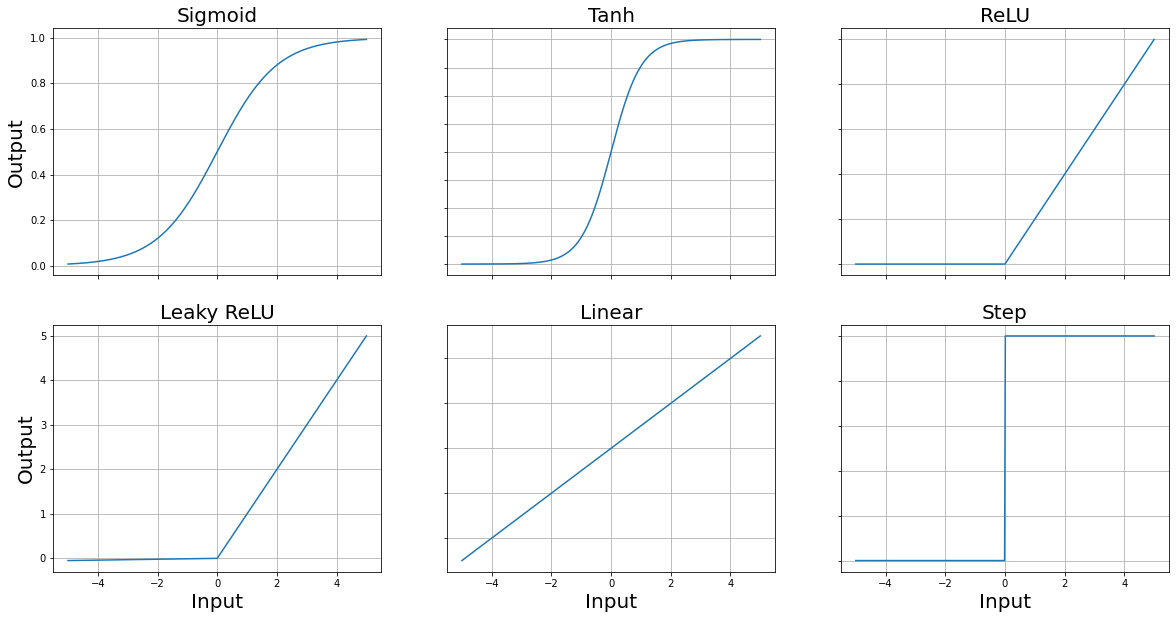

In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Define the activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def leaky_relu(x, alpha=0.01):
    return np.maximum(alpha * x, x)

def linear(x):
    return x

def step(x):
    return np.where(x >= 0, 1, 0)

# Generate x values
x = np.linspace(-5, 5, 400)

# Calculate y values for each activation function
y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)
y_leaky_relu = leaky_relu(x)
y_linear = linear(x)
y_step = step(x)

# Plotting
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

plt.rc('axes', titlesize=20)

axs[0,0].plot(x, y_sigmoid, label='Sigmoid')
axs[0,0].set_title('Sigmoid')
axs[0,1].plot(x, y_tanh, label='Tanh')
axs[0,1].set_title('Tanh')
axs[0,2].plot(x, y_relu, label='ReLU')
axs[0,2].set_title('ReLU')
axs[1,0].plot(x, y_leaky_relu, label='Leaky ReLU')
axs[1,0].set_title('Leaky ReLU')
axs[1,1].plot(x, y_linear, label='Linear')
axs[1,1].set_title('Linear')
axs[1,2].plot(x, y_step, label='Step')
axs[1,2].set_title('Step')


for ax in axs.flat:
    x_label = ax.set_xlabel('Input')
    y_label = ax.set_ylabel('Output')
    x_label.set_size(20) 
    y_label.set_size(20)  
    ax.grid(True)

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()


## Neural Networks

- For each neuron, we define three properties
    1. **Weight:** between each two connected neurons weight defines what is the importance of the previous neuron to the next one.
    2. **Bias:** Offset or bias is a intrinsic property/parameter of each of the neuron.
    3. **Activation function:** Input of each neuron is defined as the weighted sum $z=\sum_j w_j y_j +b$. If the activation function is $f$ for the neuron then output would be $f(z)$.


```{figure} images/sing_neur.png
---
height: 200px
name:   sing_neur
align:  center
---
"Weights and bias of a sigle output neuron"
```


```{figure} images/nnetwork.png
---
height: 250px
name:   nnetwork
align:  center
---
"A neural network"
```

## Implementation

There are several popular python packages for implementing neural networks like **Tensorflow**, **Pytorch** etc. In this course we will only focus on **Pytorch**. In all the packages, the core ideas remains the same

1. **Feed-Forward**
    - For each layer the input $a$ ($a=x$ for the first layer) is multiplied by weights $W$, added to biases $b$, then passed through as activation function $f$. Therefore, for the $l^{th}$ layer and $i^{th}$ neuron we have the output
  
    $$
    z^{l}_i = \sum_{j=1}^{h_l} f(w^{(l,l-1)}_{ij}z^{l-1}_j+b_{i}^{l})
    $$

    where $h_l$ is the number of hidden nodes at the $l^{th}$ layer. Note that here we are using $h_0=len(x)$.
    - Note that here the network/model parameters $\theta$ includes all weights and biases as a whole.
    - Output propagates from input layer through hidden layers to the output.



2. **Back-Propagation**
    - Compute loss $\mathcal{L}(\hat{y},y;\theta)$ where $\hat{y}$ is the network output and $y$ is the true output.
    - Use the chain rule to compute $\frac{\partial \mathcal{L}}{\partial W_{ij}^{(l,l-1)}}$ and $\frac{\partial \mathcal{L}}{\partial b_i^{l}}$ for each layer $l$, propagating the error backward.



3. **Gradient Descent**
    - Update each parameter $\theta \in {w,b}$ by
    $$
    \theta \leftarrow \theta - \alpha \frac{\partial \mathcal{L}}{\partial \theta}
    $$
    where $\alpha$ is the learning rate.


## <span style="color:maroon"> A neural network from scratch </span>

In this case we are writing a neural network just using *numpy*. and observing the outputs using *matplotlib*. The first job is always to call required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt # for plotting
import matplotlib
matplotlib.rcParams['figure.dpi']=300

In [2]:
def net_f_df_sigmoid(z): # calculate f(z) and f'(z)
    val = 1/(1 + np.exp(-z)) # sigmoid
    return(val,np.exp(-z)*(val**2)) # return both f and f'

def net_f_df_relu(z): # calculate f(z) and f'(z)
    val=z*(z>0)
    return(val,z>0) # return both f and f'

In [3]:
def forward_step(y,w,b): # calculate values in next layer, from input y
    z=np.dot(y,w)+b # w=weights, b=bias, performing the weighted sum
    return(net_f_df_relu(z)) # applying the activation function and returning both f and df

In [4]:
def apply_net(y_in): # forward pass through the network, only once
    global Weights, Biases, NumLayers # Try not using global by making all of these as a single class
    global y_layer, df_layer # for storing y-values and df/dz values
    
    y = y_in # start with input values
    y_layer[0] = y
    for j in range(NumLayers): # loop through all layers
        # j=0 corresponds to the first layer above the input
        y,df = forward_step(y,Weights[j],Biases[j]) # one step at a time
        df_layer[j] = df # store f'(z) [needed later in backprop]
        y_layer[j+1] = y # store f(z) [also needed in backprop]        
    return(y)

In [5]:
def backward_step(delta,w,df): 
    return( np.dot(delta,np.transpose(w))*df )

def backprop(y_target): # one backward pass through the network
    global y_layer, df_layer, Weights, Biases, NumLayers
    global dw_layer, db_layer # dCost/dw and dCost/db 
    global batchsize
    
    delta = (y_layer[-1]-y_target)*df_layer[-1]
    dw_layer[-1] = np.dot(np.transpose(y_layer[-2]),delta)/batchsize
    db_layer[-1] = delta.sum(0)/batchsize
    for j in range(NumLayers-1):
        delta = backward_step(delta,Weights[-1-j],df_layer[-2-j])
        dw_layer[-2-j] = np.dot(np.transpose(y_layer[-3-j]),delta)
        db_layer[-2-j] = delta.sum(0)/batchsize

In [6]:
def gradient_step(eta): # update weights & biases with the learning rate eta
    global dw_layer, db_layer, Weights, Biases
    
    for j in range(NumLayers):
        Weights[j]-=eta*dw_layer[j]
        Biases[j]-=eta*db_layer[j]

In [7]:
def train_net(y_in,y_target,eta): # one full training batch
    global y_out_result
    
    y_out_result = apply_net(y_in)
    backprop(y_target)
    gradient_step(eta)
    cost = ((y_target-y_out_result)**2).sum()/batchsize
    return(cost)

- Now we are ready to test this above network. let us first define our own function that we want the network to learn

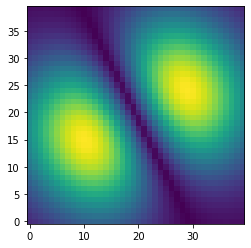

In [8]:
def myFunc(x0,x1):
    r2=x0**2+x1**2
    return(np.exp(-7*r2)*np.abs(x1+2*x0))

xrange = np.linspace(-0.5,0.5,40)
X0,X1 = np.meshgrid(xrange,xrange)
plt.imshow(myFunc(X0,X1),interpolation='nearest',origin='lower') # Only shows array indices not the actual range
plt.show()

In [9]:
def make_batch():
    global batchsize

    inputs = np.random.uniform(low=-0.5,high=+0.5,size=[batchsize,2])
    targets = np.zeros([batchsize,1]) # must have right dimensions
    targets[:,0] = myFunc(inputs[:,0],inputs[:,1])
    return(inputs,targets)

In [ ]:
# Let us first create the network

# set up all the weights and biases

NumLayers = 2 # does not count input-layer (but does count output)
LayerSizes = [2,100,1] # input-layer,hidden-1,hidden-2,...,output-layer

# initialize random weights and biases for all layers
Weights = [np.random.uniform(low=-0.1,high=+0.1,size=[ LayerSizes[j],LayerSizes[j+1] ]) for j in range(NumLayers)]
Biases = [np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]

# define the batchsize
batchsize=100

# In our case, we also need to define some helper variables to make sure the back propagation works

y_layer = [np.zeros([batchsize,LayerSizes[j]]) for j in range(NumLayers+1)]
df_layer = [np.zeros([batchsize,LayerSizes[j+1]]) for j in range(NumLayers)]
dw_layer = [np.zeros([LayerSizes[j],LayerSizes[j+1]]) for j in range(NumLayers)]
db_layer = [np.zeros(LayerSizes[j+1]) for j in range(NumLayers)]

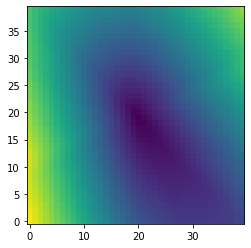

In [11]:
# First we try without training the network

def apply_net_simple(y_in): # one forward pass through the network
    # no storage for backprop (for simple tests)

    y = y_in # start with input values
    y_layer[0] = y
    for j in range(NumLayers): # loop through all layers
        # j = 0 corresponds to the first layer above the input
        y,df = forward_step(y,Weights[j],Biases[j]) # one step
    return(y)

# Choose some area in the 2D plane
test_batchsize = np.shape(X0)[0]*np.shape(X0)[1]
testsample = np.zeros([test_batchsize,2])
testsample[:,0] = X0.flatten()
testsample[:,1] = X1.flatten()

testoutput = apply_net_simple(testsample)
myim = plt.imshow(np.reshape(testoutput,np.shape(X0)),origin='lower',interpolation='none')
plt.show()

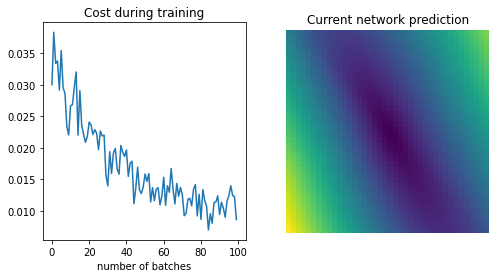

In [12]:
# import functions for updating display 
# (simple animation)
from IPython.display import clear_output
from time import sleep

eta = 0.01 # learning rate
nsteps = 100

costs = np.zeros(nsteps)
for j in range(nsteps):
    clear_output(wait = True)
    fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(8,4)) # prepare figure
    ax[1].axis('off') # no axes
    
    # the crucial lines:
    y_in,y_target = make_batch() # random samples (points in 2D)
    costs[j] = train_net(y_in,y_target,eta) # train network (one step, on this batch)
    testoutput = apply_net_simple(testsample) # check the new network output in the plane
    
    img = ax[1].imshow(np.reshape(testoutput,np.shape(X0)),interpolation='nearest',origin='lower') # plot image
    ax[0].plot(costs)
    
    ax[0].set_title("Cost during training")
    ax[0].set_xlabel("number of batches")
    ax[1].set_title("Current network prediction")
    plt.show()
    sleep(0.1)

### Using PyTorch

We will now learn implementing the above steps in PyTorch by fitting a simple dataset where 
$$
y= 0.1 x^3 - 0.5 x^2 + 2 \sin(3x),\quad x \in [-2,2]
$$
First we plot the “ground truth” curve we want our network to learn. No noise—this is a deterministic regression task.
Then we convert our *NumPy* arrays into PyTorch tensors and wrap them in a **DataLoader** so we can batch them during training.

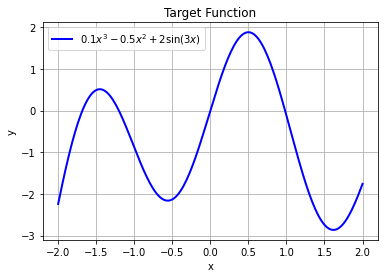

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchinfo import summary

# Generate 200 points in [-2,2]
X_np = np.linspace(-2, 2, 200).reshape(-1,1)
# Define f(x) = 0.1 x^3 - 0.5 x^2 + 2 sin(3x)
Y_np = 0.1*X_np**3 - 0.5*X_np**2 + 2*np.sin(3*X_np)

# Plot the true function
plt.figure(figsize=(6,4))
plt.plot(X_np, Y_np, 'b-', linewidth=2,
         label=r'$0.1x^3 -0.5x^2 +2\sin(3x)$')
plt.xlabel('x'); plt.ylabel('y')
plt.title('Target Function')
plt.legend(); plt.grid(True)
plt.show()



In [14]:
# Convert to PyTorch tensors & DataLoader

import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to float32 tensors
X = torch.from_numpy(X_np).float()  # shape (200,1)
Y = torch.from_numpy(Y_np).float()  # shape (200,1)

# Create a 80/20 train/validation split
dataset = TensorDataset(X, Y)
val_size   = int(0.2 * len(dataset))
train_set, val_set = torch.utils.data.random_split(
    dataset, [len(dataset)-val_size, val_size]
)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=32)


#### Defining the Model

We define a simple feed‐forward network SimpleNet with one hidden layer of size $32$ and *ReLU* activation.

In [17]:
import torch.nn as nn

class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        return self.net(x)

model     = SimpleNet()


### ❓ Exercise
**Q5:** What is the total number of trainable parametrs for the above network?
<details>
<summary>Click to show answer</summary>

Answer: answer = 97. The total number can be known using *summary(model)*.

</details>

We must choose a learning rate, decide how many epochs to train, and pick an optimizer. We’ll use plain stochastic gradient descent (SGD) here, but you can swap in Adam or others.

In [19]:
# Hyper-parameters
learning_rate = 1e-2
num_epochs    = 100

For regression, we commonly use mean squared error (MSE). We instantiate nn.MSELoss(). For parameter updates, we pass our model’s parameters and the learning rate to an optimizer, here **torch.optim.SGD**.

In [ ]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

Each epoch, we iterate over mini-batches from our DataLoader. For each batch we:

1. Zero out any stored gradients.

2. Run a forward pass to compute predictions.

3. Compute loss against true y.

4. Call loss.backward() to back-propagate gradients.

5. Call optimizer.step() to update weights.

We’ll also track and plot training vs. validation loss for diagnosing over-/under-fitting. To illustrate everything together, we create a helper train_and_plot that takes any model instance, trains it for a given number of epochs and learning rate, then plots:

1. Training loss curve

2. Final prediction curve vs original function.

In [6]:
def train_and_evaluate(model, epochs, lr, early_stop=False, patience=5):
    """
    Trains `model` for up to `epochs` with LR `lr`.
    If `early_stop=True`, monitors validation loss and stops after `patience` non-improving epochs.
    Always reloads the best model before plotting.
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    train_losses, val_losses = [], []
    best_val = float('inf')
    best_epoch = 0
    wait = 0

    for epoch in range(1, epochs + 1):
        # — Training —
        model.train()
        running_train = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()
            running_train += loss.item() * xb.size(0)
        train_losses.append(running_train / len(train_loader.dataset))

        # — Validation —
        model.eval()
        running_val = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                running_val += criterion(model(xb), yb).item() * xb.size(0)
        val_loss = running_val / len(val_loader.dataset)
        val_losses.append(val_loss)

        # — Check for improvement —
        if val_loss < best_val:
            best_val = val_loss
            best_epoch = epoch
            wait = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            wait += 1
            if early_stop and wait >= patience:
                print(f"→ Early stopping at epoch {epoch} (best at {best_epoch})")
                break

    # Reload the best‐seen weights
    model.load_state_dict(torch.load('best_model.pt'))

    # — Plot Loss Curves —
    plt.figure(figsize=(6,3))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses,   label='Val   Loss')
    if early_stop:
        plt.axvline(best_epoch, color='red', linestyle='--',
                    label=f'Best Epoch {best_epoch}')
    plt.title('Loss Curves')
    plt.xlabel('Epoch'); plt.ylabel('MSE')
    plt.legend(); plt.grid(True)
    plt.show()

    # — Plot Final Fit —
    with torch.no_grad():
        preds = model(X).numpy()
    plt.figure(figsize=(6,4))
    plt.scatter(X_np, Y_np, s=10, label='True samples')
    plt.plot(X_np, preds, 'r-', label='Model prediction')
    plt.xlabel('x'); plt.ylabel('y')
    plt.title('Final Model Fit')
    plt.legend(); plt.grid(True)
    plt.show()

    #return best_epoch


#### Over-fitting vs Under-fitting
- **Under-fitting** occurs when both training and validation error remain high-- *your model is too simple*.

- **Over-fitting** occurs when training error is low but validation error rises —- *your model is too complex or trained too long*.

##### Illustrating Under-fitting

Train with only 5 epochs—the network hasn’t had enough time to capture the sine pattern.

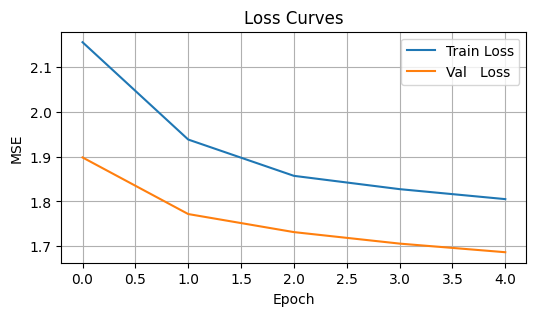

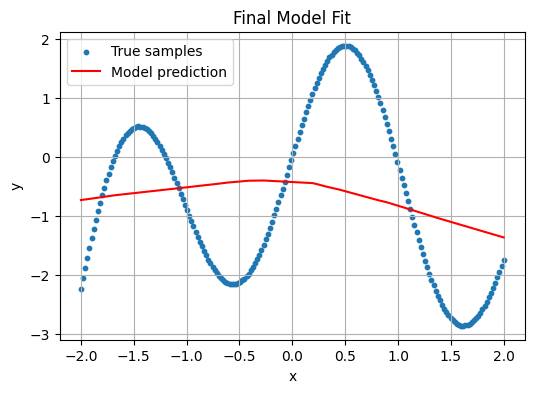

In [7]:
model_under = SimpleNet()
train_and_evaluate(model_under,
                   epochs=5,      # very few epochs
                   lr=1e-2,
                   early_stop=False)


- **Observation:** The training loss remains relatively high, and the red prediction curve is too flat or linear.

##### Illustrating Over-fitting

Increase capacity to 512 hidden units and train for 500 epochs—the model will “memorize” evrything.

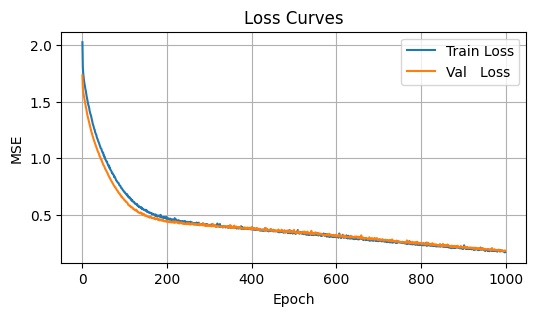

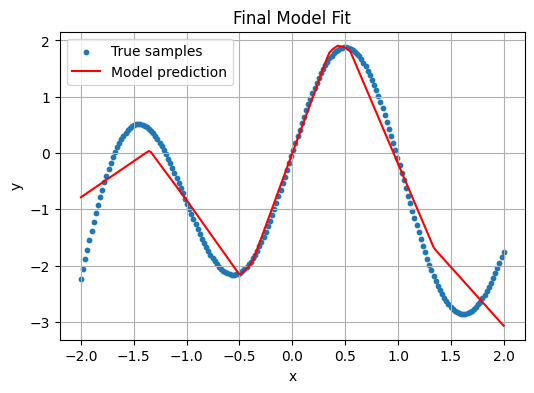

In [8]:
# Increase capacity: 1→512→1 network
class LargeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 512),
            nn.ReLU(),
            nn.Linear(512, 1)
        )
    def forward(self, x):
        return self.net(x)

model_over = SimpleNet()
train_and_evaluate(model_over,
                   epochs=1000,
                   lr=1e-2,
                   early_stop=False)



- **Observation:** Training loss drops near zero, but the final fit oscillates wildly, chasing every noisy point. It **over-fits** the deterministic function’s high-frequency component.

#### Adding Early Stopping

Finally, we demonstrate early stopping on the large model: we’ll monitor validation loss and halt training if it fails to improve for 10 consecutive epochs.

→ Early stopping at epoch 626 (best at 606)


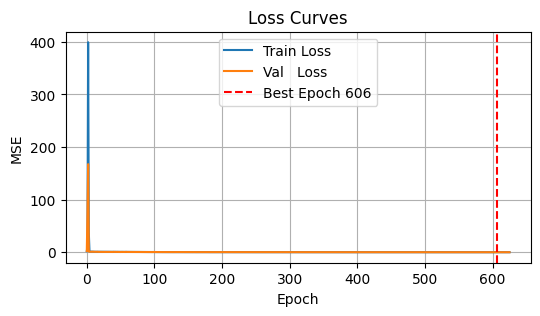

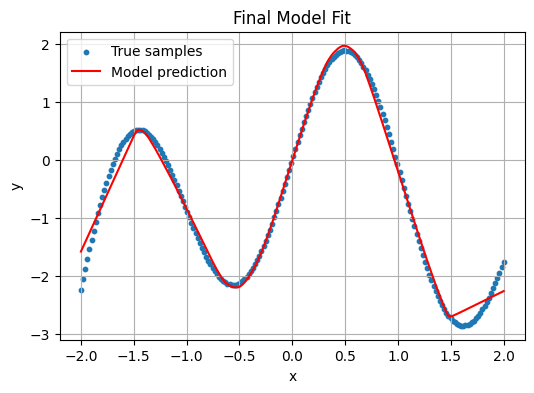

In [11]:
model_es = LargeNet()
stop_epoch = train_and_evaluate(model_es,
                                epochs=1000,
                                lr=1e-2,
                                early_stop=True,
                                patience=20)
